# Importing the required libraries

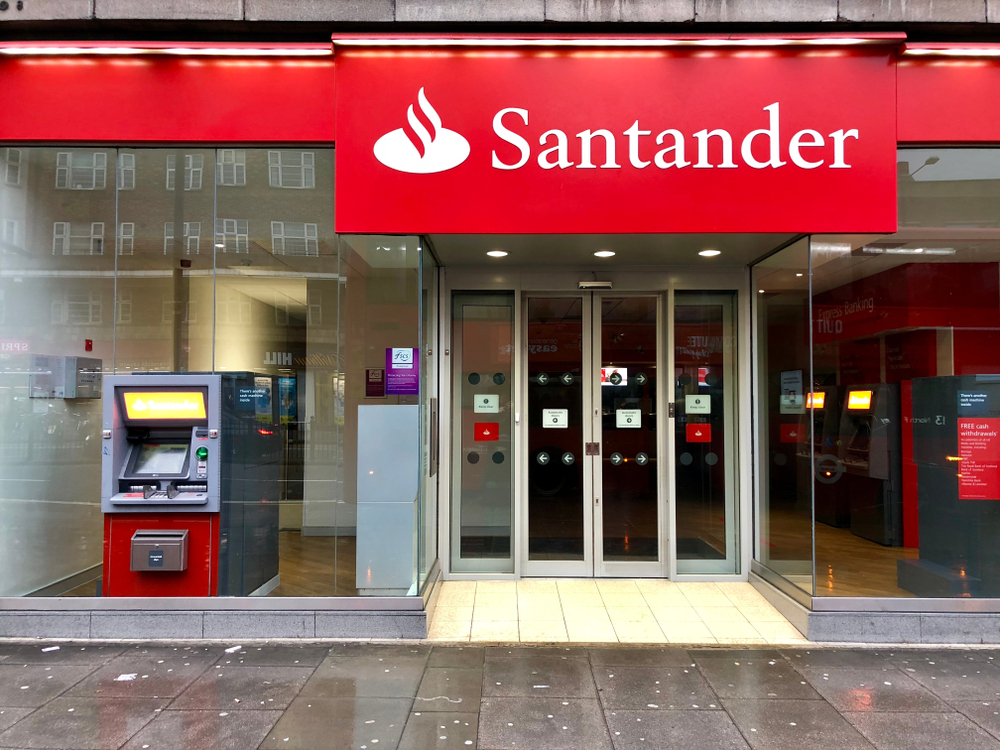

In [39]:
from IPython.display import Image
Image("santander.jpg")

In [2]:
#Importing the required libraries
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
import time

# Loading the data frames

In [5]:
%%time
train=pd.read_csv('train.csv') #Reading the train Data

Wall time: 14.5 s


In [6]:
train.head() #Having a look at the train data

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
%%time
test=pd.read_csv('test.csv') #Reading the test data

Wall time: 16.3 s


In [8]:
test.head() #Having a look at the test data

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


# Data Exploration

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [39]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [73]:
train.shape

(200000, 202)

In [42]:
test.shape

(200000, 201)

In [54]:
#Function to get missing data information
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [59]:
#Function to get the train missing data details
%%time
missing_data(train)

Wall time: 5.33 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [60]:
%%time
missing_data(test)

Wall time: 3.15 s


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [19]:
%%time
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Wall time: 58.9 s


In [20]:
#Having a look at newly created features
train[train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [21]:
test[test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


# Model

In [22]:
#Dropping the id and target from train data
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [23]:
#Hyperparameters definition for the model
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [35]:
#Running the model
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

In [36]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900229	valid_1's auc: 0.881617
[2000]	training's auc: 0.91128	valid_1's auc: 0.889429
[3000]	training's auc: 0.918765	valid_1's auc: 0.893439
[4000]	training's auc: 0.924616	valid_1's auc: 0.895931
[5000]	training's auc: 0.929589	valid_1's auc: 0.897627
[6000]	training's auc: 0.933851	valid_1's auc: 0.898744
[7000]	training's auc: 0.937859	valid_1's auc: 0.899323
[8000]	training's auc: 0.941551	valid_1's auc: 0.899795
[9000]	training's auc: 0.945163	valid_1's auc: 0.89989
[10000]	training's auc: 0.948511	valid_1's auc: 0.900163
[11000]	training's auc: 0.951767	valid_1's auc: 0.900283
[12000]	training's auc: 0.954859	valid_1's auc: 0.90023
[13000]	training's auc: 0.957775	valid_1's auc: 0.900054
[14000]	training's auc: 0.960624	valid_1's auc: 0.899878
Early stopping, best iteration is:
[11710]	training's auc: 0.95397	valid_1's auc: 0.900332
Fold 1
Training until validation scores don't improv

[9000]	training's auc: 0.945154	valid_1's auc: 0.901195
[10000]	training's auc: 0.948591	valid_1's auc: 0.901266
[11000]	training's auc: 0.95175	valid_1's auc: 0.901279
[12000]	training's auc: 0.95483	valid_1's auc: 0.901261
[13000]	training's auc: 0.957797	valid_1's auc: 0.901296
Early stopping, best iteration is:
[10890]	training's auc: 0.951424	valid_1's auc: 0.901361
CV score: 0.90022 


# Submission

In [38]:
#We make the submissions now
sub=pd.DataFrame({"ID_code":test["ID_code"].values})
sub["target"]=predictions
sub.to_csv("submission.csv",index=False)

In [40]:
pd.read_csv('submission.csv').head()

,ID_code,target
0,test_0,0.110542
1,test_1,0.220118
2,test_2,0.190777
3,test_3,0.203538
4,test_4,0.040816
